In [1]:
import numpy as np
import openturns as ot
from depimpact import ConservativeEstimate, quantile_func, iterative_vine_minimize
from depimpact.plots import set_style_paper, plot_iterative_results

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns

set_style_paper()
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext memory_profiler

In [48]:
def func(X):
    X = np.asarray(X)
    return - X.sum(axis=1)

In [97]:
dim = 5
marginal = ot.GeneralizedPareto(1., .1)
margins = [marginal]*dim
families = np.zeros((dim, dim))
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1
q_estimate = ConservativeEstimate(func, margins, families)

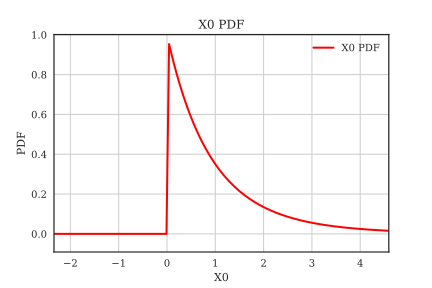

In [98]:
marginal = ot.GeneralizedPareto(1., .1)
marginal.drawPDF()

In [99]:
#%%mprun -f q_estimate.gridsearch
n = 200000
n_theta = 200
grid_results_lhs = q_estimate.gridsearch(n_theta, n, keep_input_samples=False, use_sto_func=True)

Time taken: 1377.8808996544758
Creating grid
Time taken: 1378.3762729668306
Converting to kendall parameters
Time taken: 1378.5208856990853
Sample evaluation
Time taken: 1379.3852076638352
Iteration 0
Time taken: 1397.3389604215918
Iteration 20
Time taken: 1416.988462260222
Iteration 40
Time taken: 1436.2388912865276
Iteration 60
Time taken: 1454.5871772013627
Iteration 80
Time taken: 1470.8478231894335
Iteration 100
Time taken: 1487.0594210400918
Iteration 120
Time taken: 1503.1794151196234
Iteration 140
Time taken: 1519.7546430180194
Iteration 160
Time taken: 1536.2809821181459
Iteration 180


In [100]:
indep_result = q_estimate.independence(n_input_sample=n)
indep_result.q_func = q_func

In [105]:
alpha = 0.1
q_func = quantile_func(alpha)

In [106]:
n_boot = 10
ci_prob = [0.025, 0.975]
indep_result.q_func = q_func
indep_result.compute_bootstrap(n_boot)
indep_boot_ci = indep_result.compute_quantity_bootstrap_ci(ci_prob)
indep_boot_mean = indep_result.boot_mean
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (indep_boot_mean, indep_result.boot_cov*100.))

Quantile at independence: -9.17 with a C.O.V at 0.1 %


In [107]:
grid_results.q_func = q_func
quantities = grid_results.quantities
kendalls = grid_results.kendalls
min_result_grid = grid_results.min_result
min_kendall = min_result_grid.kendall_tau
min_quant = min_result_grid.quantity

min_result_grid.compute_bootstrap(n_boot)
grid_boot_ci = min_result_grid.compute_quantity_bootstrap_ci(ci_prob)
print('Min quantile for grid-search: %.2f with a C.O.V at %.1f %%' % (min_result_grid.boot_mean, min_result_grid.boot_cov*100.))

Min quantile for grid-search: -12.64 with a C.O.V at 0.3 %


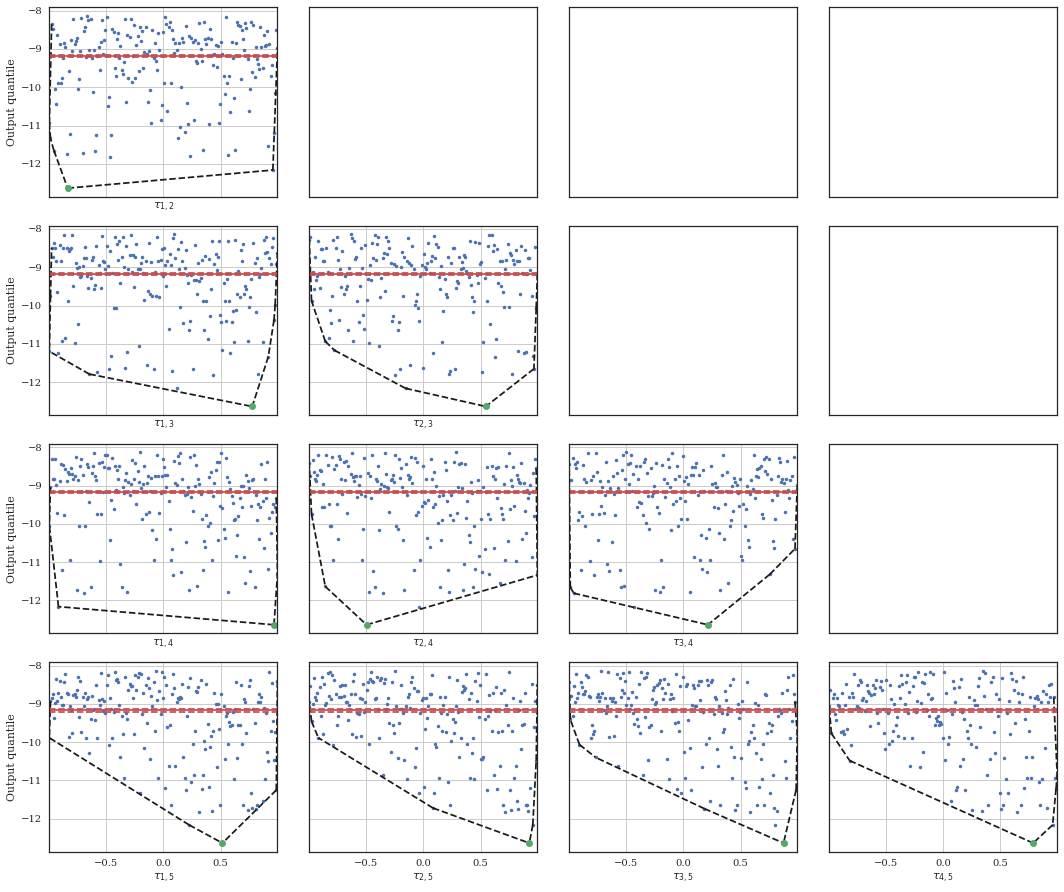

In [108]:
with_perfect = False
middle_quant = quantities.mean()
fig, axes = plt.subplots(dim-1, dim-1, figsize=(3*dim, 2.5*dim), sharex=True, sharey=True)
k = 0
n_pairs = int(dim * (dim-1)/2)
for i in range(dim-1):
    for j in range(i+1):
        if dim == 2:
            ax = axes
        else:
            ax = axes[i, j]
        kendalls_k = kendalls[:, k]
        theta_min, theta_max = kendalls.min(), kendalls.max()
        ax.plot(kendalls_k, quantities, '.')
        points = np.asarray([kendalls_k, quantities]).T
        hull = ConvexHull(points, True)
        for simplex in hull.simplices:
            if points[simplex, 1].min() < middle_quant:
                ax.plot(points[simplex, 0], points[simplex, 1], 'k--')
        ax.plot(min_kendall[k], min_quant, 'o')
        ax.plot([theta_min, theta_max], [indep_boot_mean]*2, 'r')
        ax.plot([theta_min, theta_max], [indep_boot_ci[0]]*2, '--r')
        ax.plot([theta_min, theta_max], [indep_boot_ci[1]]*2, '--r')
        
        if with_perfect:
            others = list(range(n_pairs))
            others.remove(k)
            for kk in others:
                id_countermono = kendalls[:, kk] <= -0.99
                id_countmono = kendalls[:, kk] >= 0.99
                ax.plot(params[id_countermono], quantities[id_countermono], 'o', label='')
                ax.plot(params[id_countmono], quantities[id_countmono], 'o', label='')
        ax.set_xlim(theta_min, theta_max)        
        ax.set_xlabel('$\\tau_{%d, %d}$' % (j+1, i+2))
        ax.grid()
        
        if j == 0:
            ax.set_ylabel('Output quantile')
            
        k += 1
        
fig.tight_layout()